# Build a binary classifier
### With a feature function drawn from a normal distribution

**Name: Dahye Kim (김다혜)**  
**ID: 20153712**  
**Date: 06 December 2018**  
**Project Github:** https://github.com/joyfuldahye/MFCVML_Assignments/tree/master/Assignment10  

**Requirements** 

* Define a linear bi-partitioning function $\tilde{f}_n$ to classify digit $n = 0,1,...,9$ against all the other digits using **training data** at MNIST dataset
* Define the classifier $\hat{f}(x) = argmax_n\tilde{f}_n(x)$ using the $arg max$ over the index for the digits.  
* Evaluate the performance of the classifier $\hat{f}$ using **testing data** at MNIST dataset based on $F_1$ score

* Let $x = (x_1, x_2, ..., x_{784})$ be a vector that represent an image of the size 28 x 28 (vectorised by column-wise)
* Let $f_i$ be a feature function such that $f_i:\mathbb{R}^{784} \to \mathbb{R}:$  
$f_i(x) = r_i^{T}x, \space r_i \sim N(0,\sigma),\space r_i \in \mathbb{R}^{784}$  
  where $r_i$ denotes a random vector drawn from a normal distribution. (function: numpy.random.normal)
* The partitioning function $\tilde{f}: \mathbb{R}^{784} \to \mathbb{R}$ is defined by:  
$\tilde{f}(x;\theta)=\theta_1f_1(x)+\theta_2f_2(x)+...+\theta_{p}f_{p}(x)$ 
    where $\theta = (\theta_1, \theta_2,...,\theta_{p})$ denotes the model parameters

**Essential Visualisation**

* Try with varying the number of parameters $p$ with the standard deviation $\sigma = 1$ of the random feature vector $r$  
* Present the confusion matrix $M(i,j)$ that indicates the number of classification for the digit $i$ as the digit $j$
* Present the best $F_1$ score among the results with different number of parameters $p$  
  * $F_1$ score $= 2 * \frac{precision*recall}{precision+recall}$
  * Precision $= \frac{True positive}{All positive}$
  * Recall $= \frac{True positive}{True positive + False negative}$


-----------------------------------------------------------------------

## Import libraries and define variables

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

# for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Define data loader class for MNIST  
* **generate_feature_functions**
  * feature function $f_i:\mathbb{R}^{784} \to \mathbb{R}:$  
$f_i(x) = r_i^{T}x, \space r_i \sim N(0,\sigma),\space r_i \in \mathbb{R}^{784}$  
  where $r_i$ denotes a random vector drawn from a normal distribution. (function: numpy.random.normal)

In [2]:
# mnist data loader
class MnistDataLoader(object):
    def __init__(self, file_data_train, file_data_test, num_parameters, mu, sigma, size_row=28, size_col=28):
        h_data_train    = open(file_data_train, "r")
        h_data_test     = open(file_data_test, "r")
        
        # raw data
        self.data_train = h_data_train.readlines()
        self.data_test = h_data_test.readlines()
        self.num_train   = len(self.data_train)   # number of training images
        self.num_test    = len(self.data_test)    # number of testing images
        h_data_train.close()
        h_data_test.close()
        
        # info data 
        self.size_row = size_row
        self.size_col = size_col
        self.data_length = self.size_row * self.size_col
        
        # preprocessing data
        self.list_image_train    = np.empty((self.size_row * self.size_col, self.num_train), dtype=float)
        self.list_label_train    = np.empty(self.num_train, dtype=int)

        self.list_image_test     = np.empty((self.size_row * self.size_col, self.num_test), dtype=float)
        self.list_label_test     = np.empty(self.num_test, dtype=int)
        
        self.preprocess_data()
        
        # set parameters
        self.p = num_parameters
        self.mu = mu
        self.sigma = sigma
        
        # set feature vectors
        self.generate_feature_vectors()
        
        # init prediction result
        self.prediction = 0
        

    def normalize(self, data):
        data_normalized = (data - min(data)) / (max(data) - min(data))
        return(data_normalized)
        
    def preprocess_data(self):
        for count, line in enumerate(self.data_train):
            line_data   = line.split(',')
            label       = line_data[0]
            im_vector   = np.asfarray(line_data[1:])
            im_vector   = self.normalize(im_vector)

            self.list_label_train[count]     = label
            self.list_image_train[:, count]  = im_vector    

        for count, line in enumerate(self.data_test):
            line_data   = line.split(',')
            label       = line_data[0]
            im_vector   = np.asfarray(line_data[1:])
            im_vector   = self.normalize(im_vector)

            self.list_label_test[count]      = label
            self.list_image_test[:, count]   = im_vector   
            
    # generate basis functions with varing p
    def generate_feature_vectors(self):
        self.basis_functions = np.zeros((self.data_length, self.p), dtype=float)
        self.feature_vectors = np.zeros((self.p, self.num_train), dtype=float)
        for i in range(self.p):
            random_normal_vector = np.random.normal(self.mu, self.sigma, self.data_length)
            self.basis_functions[:,i] = random_normal_vector
        for data in range(self.num_train):
            for p in range(self.p):
                self.feature_vectors[p, data] = np.sum(self.basis_functions[:, p] * self.list_image_train[:, data])
                
#     def generate_basis_functions(self):
#         self.basis_functions = np.zeros((self.data_length, self.p), dtype=float)
#         for i in range(self.p):
#             random_normal_vector = np.random.normal(self.mu, self.sigma, self.data_length)
#             self.basis_functions[:,i] = random_normal_vector

## Define a bi-classifier class to detect 'k' with sign function


* **Initialisation**
  * set learning rate
  * randomly initailse the first model parameters

* **Predict with sign function**
  * $sign(x) =   \begin{cases}
    +1       & \quad \text{if } x \geq0\\
    -1  & \quad \text{if } x \text{ < 0}
  \end{cases}$
* **Update model parameters**
  * $\theta_p =   \begin{cases}
    \theta_p + (1 * \alpha * x_i)       & \quad \text{if } \hat{f}(x) = -1 but\space y = 1 \
    \\
     \theta_p + (-1 * \alpha * x_i)  & \quad \text{if }  \hat{f}(x) = 1 but\space y = -1
  \end{cases}$
    * where $\alpha = learning\space rate$
    * where $x_i = r_p^{T}x_j$

In [3]:
# classifier using argmax function
class MultiBinaryClassifier(object):
    def __init__(self, data_loader, learning_rate):
        self.data_loader = data_loader
        
        self.num_parameter = self.data_loader.p
        self.learning_rate = learning_rate
        self.basis_functions = self.data_loader.basis_functions
        # init the model parameters (randomly)
        self.model_parameters = np.random.uniform(-1, 1, self.num_parameter)
        self.list_updated_model_parameters = [self.model_parameters]

    def predict(self, x):
        if np.sum(x * self.model_parameters) >= 0:
            return 1
        else:
            return -1

    def update_model_parameters(self, x, y):
        if self.predict(x) != y: # if prediction is false
#         if self.data_loader.prediction != y: # if prediction is false
            if y == 1: # when false negative
                for j in range(self.data_loader.p):
                    change = (1 * self.learning_rate * x[j])
                    new_parameter = (self.model_parameters[j] + change)
                    self.model_parameters[j] = new_parameter
            else: # when false positive
                for j in range(self.data_loader.p):
                    change = (-1 * self.learning_rate * x[j])
                    new_parameter = self.model_parameters[j] + change
                    self.model_parameters[j] = new_parameter
        else:
            self.model_parameters = self.model_parameters

## Define a trainer class with sign function  
* **Initialisation**  
  * Assign new labels to train and test images $if\space k \to 1,$ $if \space not\space k \to -1$
* **Train**  
  * Execute prediction and update model parameters as much as given epoch

In [4]:
# Multi Trainer
class MultiBinaryTrainerWithSign(object):
    def __init__(self, classifier, data_loader):
        self.classifier = classifier
        self.data_loader = deepcopy(data_loader)
        self.prediction_result_train = []
        self.multi_train_labels = np.zeros((10, self.data_loader.num_train), dtype=float)
        #self.multi_test_labels = np.zeros((10, self.data_loader.num_test), dtype=float)
        
        # change train label 
        for label in range(10):
            for i, train_label in enumerate(self.data_loader.list_label_train):
                if train_label == label:
                    self.multi_train_labels[label, i] = 1
                else:
                    self.multi_train_labels[label, i] = -1
        
        # change test label
        for i, test_label in enumerate(self.data_loader.list_label_test):
            if test_label == 0:
                self.data_loader.list_label_test[i] = 1
            else:
                self.data_loader.list_label_test[i] = -1
        

    def train(self, num_epoch):
        self.label_model_parameters = []
        for label in range(10):
            print(f'bi-train for label {label}')
            self.classifier.model_parameters = np.random.uniform(-1, 1, self.data_loader.p)
            for e in range(num_epoch):
                self.prediction_result_train = []
                num_collect = 0
                
                for i in range(self.data_loader.num_train):
                    x = self.data_loader.feature_vectors[:, i]
                    y = self.multi_train_labels[label, i]
                    self.data_loader.prediction = self.classifier.predict(x)
                    self.prediction_result_train.append(self.data_loader.prediction)

                    if y == self.data_loader.prediction:
                        num_collect += 1

                    self.classifier.update_model_parameters(x, y)
                print('Epoch=%d, Accuracy=%.6f' % (e, num_collect / self.data_loader.num_train))
            self.label_model_parameters.append(self.classifier.model_parameters)

## Define a classifier to decide label using argmax
* **Predict with argmax**
  * Define the classifier $\hat{f}(x) = argmax_{k=1,...,10}\tilde{f}_k(x)$ using the $arg max$ over the index for the digits.

In [5]:
class LabelClassifier(object):
    def __init__(self, data_loader, binary_classifier, binary_trainer):
        self.data_loader = deepcopy(data_loader)
        self.binary_classifier = binary_classifier
        self.binary_trainer = binary_trainer
        
        self.real_pred_value = np.zeros(10, dtype=float)
        

    def predict_label(self, x):
        for i in range(10):
            self.real_pred_value[i] = np.sum(x * self.binary_trainer.label_model_parameters[i])
        return np.argmax(self.real_pred_value)
            

## Evaluate the train model with testing data
* $F_1$ score method:
  * $F_1$ score $= 2 * \frac{precision*recall}{precision+recall}$
  * Precision $= \frac{True positive}{All positive}$
  * Recall $= \frac{True positive}{True positive + False negative}$
* Tried two approaches to get F1 score.
  1. Without weights, just use values on confusion matrix
  2. With weights  
    * Precision weight = $\frac{number of actual k data}{number of total data}$
    * Precision weight = $\frac{number of data which is predicted as k}{number of total data}$

In [29]:
class LabelTester(object):
    def __init__(self, data_loader, binary_classifier, binary_trainer, label_classifier):
        self.data_loader = deepcopy(data_loader)
        self.binary_classifier = binary_classifier
        self.binary_trainer = binary_trainer
        self.label_classifier = label_classifier
        
        # generate feature vectors for test
        self.test()
        
    # process test data
    def test(self):
        test_num_parameter = self.data_loader.p

        test_basis_functions = self.data_loader.basis_functions
        self.test_feature_vectors = np.zeros((test_num_parameter, self.data_loader.num_test), dtype=float)
        for data in range(self.data_loader.num_test):
            for p in range(test_num_parameter):
                self.test_feature_vectors[p, data] = np.sum(test_basis_functions[:, p] * self.data_loader.list_image_test[:, data])
        return self.test_feature_vectors

    def train(self):
        accuracies = 0
        self.pred_result = []

        for i in range(self.data_loader.num_test):
            x = self.test_feature_vectors[:, i]
            y = self.data_loader.list_label_test[i]
            pred = self.label_classifier.predict_label(x)
            self.pred_result.append(pred)
            if y == pred:
                accuracies += 1
        return accuracies
    
    def plot_confusion_matrix(self):
        actual_label = self.data_loader.list_label_test
        predicted_label = self.pred_result
        cm = confusion_matrix(actual_label, predicted_label)
        cm_df = pd.DataFrame(cm,
                            index = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
                            columns = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
        self.original_cm_df = pd.DataFrame(cm,
                            index = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
                            columns = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
#         self.original_cm_df["sum"] = self.original_cm_df.sum(axis=1)
#         self.original_cm_df = self.original_cm_df.append(self.original_cm_df.agg(['sum']))
        cm_df["sum"] = cm_df.sum(axis=1)
        cm_df = cm_df.loc[:,"0":"sum"].div(cm_df["sum"], axis=0)
        cm_df = cm_df.append(cm_df.agg(['sum']))
        plt.figure(figsize=(15,7))
        sns.heatmap(cm, cmap="YlGnBu", annot = True, fmt="d")
        plt.title('Confusion Matrix of The Classifier')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print('--------Display percentaged values in a tabular form--------')
        print(cm_df)
    
    def compute_F1(self):
        column_list = ['Precision', 'Recall', 'F1 score']
        
        self.cm_matrix = self.original_cm_df.as_matrix()
        self.true_positive = np.diag(self.cm_matrix)
        num_true_positive = np.sum(self.true_positive)
        num_all_positive = self.data_loader.num_test
        
        num_false_negative = self.data_loader.num_test - num_true_positive
        
        self.precision = num_true_positive / num_all_positive
        self.recall = num_true_positive / (num_true_positive + num_false_negative)
        self.f1_score = 2 * ((self.precision*self.recall)/(self.precision+self.recall))
        
        scores = pd.Series({'Precision': self.precision, 'Recall': self.recall, 'F1 score': self.f1_score})
        print('--------Display F1 score--------')
        print(scores)

    def compute_detail_F1(self):
#         column_list = ['Precision', 'Recall', 'F1 score']
        column_list = ['Weighted Precision', 'Weighted Recall', 'Weighted F1 score']
        
        self.cm_matrix = self.original_cm_df.as_matrix()
        
        self.true_positives = []
        self.false_positives = []
        self.false_negatives = []
        self.precision_weight = []
        self.recall_weight = []
        
        self.precisions = []
        self.recalls = []
        
        self.precision_sum = 0
        self.recall_sum = 0
        
        for i in range(10):
            self.true_positives.append(self.cm_matrix[i, i])
            self.false_positives.append(sum(self.cm_matrix[:, 0]) - self.cm_matrix[i, i])
            self.false_negatives.append(sum(self.cm_matrix[0, :]) - self.cm_matrix[i, i])
            self.precision_weight.append(sum(self.cm_matrix[:,0])/self.data_loader.num_test)
            self.recall_weight.append(sum(self.cm_matrix[0,:])/self.data_loader.num_test)
            
            self.precisions.append(self.true_positives[i]/(self.true_positives[i]+self.false_positives[i]))
            self.recalls.append(self.true_positives[i]/(self.true_positives[i]+self.false_negatives[i]))
            
            self.precision_sum += self.precision_weight[i]*(self.true_positives[i]/(self.true_positives[i]+self.false_positives[i]))
            self.recall_sum += self.recall_weight[i]*(self.true_positives[i]/(self.true_positives[i]+self.false_negatives[i]))
            print(f'precision for value {i}:', self.precisions[i])
            print(f'recall for value {i}:', self.recalls[i])
            print(f'F1 score for value {i}:', 2 * ((self.precisions[i]* self.recalls[i]) / (self.precisions[i] + self.recalls[i])))
        self.f1_score = 2 * ((self.precision_sum * self.recall_sum) / (self.precision_sum + self.recall_sum))
            
#         self.true_positive = np.diag(self.cm_matrix)
#         num_true_positive = np.sum(self.true_positive)
#         num_all_positive = self.data_loader.num_test
        
#         num_false_negative = self.data_loader.num_test - num_true_positive
        
#         self.precision = num_true_positive / num_all_positive
#         self.recall = num_true_positive / (num_true_positive + num_false_negative)
#         self.f1_score = 2 * ((self.precision*self.recall)/(self.precision+self.recall))
        
#         scores = pd.Series({'Precision': self.precision, 'Recall': self.recall, 'F1 score': self.f1_score})
        scores = pd.Series({'Weighted Precision': self.precision_sum,
                            'Weighted Recall': self.recall_sum,
                            'Weighted F1 score': self.f1_score})
        print('--------Display aggregated F1 score with weight--------')
        print(scores)

## Execute train with training data
* set learning rate = 0.0001
* start from $p = 2^4$
* epoch: 20

In [7]:
# keep instances with varing p
exponents = []
data_loaders = []
multi_binary_classifiers = []
multi_binary_trainers = []
label_classifiers = []
label_testers = []

### Train with $p = 2^4$

In [8]:
# load data
mnist_data_loader_ex4 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**4, 0, 1)

In [9]:
# set multi bi-classifier
multi_binary_classifier_ex4 = MultiBinaryClassifier(mnist_data_loader_ex4, 0.0001)
# train
multi_binary_trainer_ex4 = MultiBinaryTrainerWithSign(multi_binary_classifier_ex4, mnist_data_loader_ex4)
multi_binary_trainer_ex4.train(5)
# append result
exponents.append(2**4)
data_loaders.append(mnist_data_loader_ex4)
multi_binary_classifiers.append(multi_binary_classifier_ex4)
multi_binary_trainers.append(multi_binary_trainer_ex4)

bi-train for label 0
Epoch=0, Accuracy=0.895167
Epoch=1, Accuracy=0.913700
Epoch=2, Accuracy=0.904800
Epoch=3, Accuracy=0.904183
Epoch=4, Accuracy=0.904317
bi-train for label 1
Epoch=0, Accuracy=0.925983
Epoch=1, Accuracy=0.959167
Epoch=2, Accuracy=0.962550
Epoch=3, Accuracy=0.961233
Epoch=4, Accuracy=0.950033
bi-train for label 2
Epoch=0, Accuracy=0.854300
Epoch=1, Accuracy=0.862833
Epoch=2, Accuracy=0.863017
Epoch=3, Accuracy=0.864467
Epoch=4, Accuracy=0.865067
bi-train for label 3
Epoch=0, Accuracy=0.868383
Epoch=1, Accuracy=0.874917
Epoch=2, Accuracy=0.874950
Epoch=3, Accuracy=0.875550
Epoch=4, Accuracy=0.876033
bi-train for label 4
Epoch=0, Accuracy=0.869417
Epoch=1, Accuracy=0.884517
Epoch=2, Accuracy=0.885567
Epoch=3, Accuracy=0.884450
Epoch=4, Accuracy=0.884250
bi-train for label 5
Epoch=0, Accuracy=0.854767
Epoch=1, Accuracy=0.858283
Epoch=2, Accuracy=0.856900
Epoch=3, Accuracy=0.857033
Epoch=4, Accuracy=0.856917
bi-train for label 6
Epoch=0, Accuracy=0.876200
Epoch=1, Accurac

### Train with $p = 2^6$

In [10]:
# load data
mnist_data_loader_ex6 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**6, 0, 1)

In [11]:
# set multi bi-classifier
multi_binary_classifier_ex6 = MultiBinaryClassifier(mnist_data_loader_ex6, 0.0001)
# train
multi_binary_trainer_ex6 = MultiBinaryTrainerWithSign(multi_binary_classifier_ex6, mnist_data_loader_ex6)
multi_binary_trainer_ex6.train(5)
# append result
exponents.append(2**6)
data_loaders.append(mnist_data_loader_ex6)
multi_binary_classifiers.append(multi_binary_classifier_ex6)
multi_binary_trainers.append(multi_binary_trainer_ex6)

bi-train for label 0
Epoch=0, Accuracy=0.939183
Epoch=1, Accuracy=0.962683
Epoch=2, Accuracy=0.966567
Epoch=3, Accuracy=0.967817
Epoch=4, Accuracy=0.969083
bi-train for label 1
Epoch=0, Accuracy=0.940517
Epoch=1, Accuracy=0.971233
Epoch=2, Accuracy=0.975050
Epoch=3, Accuracy=0.976333
Epoch=4, Accuracy=0.977633
bi-train for label 2
Epoch=0, Accuracy=0.900533
Epoch=1, Accuracy=0.940700
Epoch=2, Accuracy=0.944800
Epoch=3, Accuracy=0.946333
Epoch=4, Accuracy=0.946100
bi-train for label 3
Epoch=0, Accuracy=0.883033
Epoch=1, Accuracy=0.928467
Epoch=2, Accuracy=0.933317
Epoch=3, Accuracy=0.931367
Epoch=4, Accuracy=0.924467
bi-train for label 4
Epoch=0, Accuracy=0.913767
Epoch=1, Accuracy=0.944600
Epoch=2, Accuracy=0.949967
Epoch=3, Accuracy=0.952183
Epoch=4, Accuracy=0.952633
bi-train for label 5
Epoch=0, Accuracy=0.878767
Epoch=1, Accuracy=0.916450
Epoch=2, Accuracy=0.918967
Epoch=3, Accuracy=0.910650
Epoch=4, Accuracy=0.908350
bi-train for label 6
Epoch=0, Accuracy=0.924033
Epoch=1, Accurac

### Train with $p = 2^8$

In [12]:
# load data
mnist_data_loader_ex8 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**8, 0, 1)

In [13]:
# set multi bi-classifier
multi_binary_classifier_ex8 = MultiBinaryClassifier(mnist_data_loader_ex8, 0.0001)
# train
multi_binary_trainer_ex8 = MultiBinaryTrainerWithSign(multi_binary_classifier_ex8, mnist_data_loader_ex8)
multi_binary_trainer_ex8.train(5)
# append result
exponents.append(2**8)
data_loaders.append(mnist_data_loader_ex8)
multi_binary_classifiers.append(multi_binary_classifier_ex8)
multi_binary_trainers.append(multi_binary_trainer_ex8)

bi-train for label 0
Epoch=0, Accuracy=0.953333
Epoch=1, Accuracy=0.977617
Epoch=2, Accuracy=0.980483
Epoch=3, Accuracy=0.981600
Epoch=4, Accuracy=0.982567
bi-train for label 1
Epoch=0, Accuracy=0.957100
Epoch=1, Accuracy=0.980633
Epoch=2, Accuracy=0.982933
Epoch=3, Accuracy=0.983833
Epoch=4, Accuracy=0.984533
bi-train for label 2
Epoch=0, Accuracy=0.931767
Epoch=1, Accuracy=0.957967
Epoch=2, Accuracy=0.961083
Epoch=3, Accuracy=0.962350
Epoch=4, Accuracy=0.963067
bi-train for label 3
Epoch=0, Accuracy=0.921850
Epoch=1, Accuracy=0.946317
Epoch=2, Accuracy=0.950350
Epoch=3, Accuracy=0.951700
Epoch=4, Accuracy=0.953083
bi-train for label 4
Epoch=0, Accuracy=0.933967
Epoch=1, Accuracy=0.961717
Epoch=2, Accuracy=0.966183
Epoch=3, Accuracy=0.968483
Epoch=4, Accuracy=0.969700
bi-train for label 5
Epoch=0, Accuracy=0.915517
Epoch=1, Accuracy=0.941917
Epoch=2, Accuracy=0.947117
Epoch=3, Accuracy=0.949367
Epoch=4, Accuracy=0.951083
bi-train for label 6
Epoch=0, Accuracy=0.946150
Epoch=1, Accurac

### Train with $p = 2^{10}$

In [14]:
# load data
mnist_data_loader_ex10 = MnistDataLoader("mnist_train.csv", "mnist_test.csv", 2**10, 0, 1)

In [15]:
# set multi bi-classifier
multi_binary_classifier_ex10 = MultiBinaryClassifier(mnist_data_loader_ex10, 0.0001)
# train
multi_binary_trainer_ex10 = MultiBinaryTrainerWithSign(multi_binary_classifier_ex10, mnist_data_loader_ex10)
multi_binary_trainer_ex10.train(5)
# append result
exponents.append(2**10)
data_loaders.append(mnist_data_loader_ex10)
multi_binary_classifiers.append(multi_binary_classifier_ex10)
multi_binary_trainers.append(multi_binary_trainer_ex10)

bi-train for label 0
Epoch=0, Accuracy=0.964283
Epoch=1, Accuracy=0.980500
Epoch=2, Accuracy=0.982867
Epoch=3, Accuracy=0.983650
Epoch=4, Accuracy=0.984000
bi-train for label 1
Epoch=0, Accuracy=0.972000
Epoch=1, Accuracy=0.983900
Epoch=2, Accuracy=0.985083
Epoch=3, Accuracy=0.985783
Epoch=4, Accuracy=0.986350
bi-train for label 2
Epoch=0, Accuracy=0.948067
Epoch=1, Accuracy=0.963117
Epoch=2, Accuracy=0.965300
Epoch=3, Accuracy=0.966317
Epoch=4, Accuracy=0.966717
bi-train for label 3
Epoch=0, Accuracy=0.939367
Epoch=1, Accuracy=0.951683
Epoch=2, Accuracy=0.953317
Epoch=3, Accuracy=0.954900
Epoch=4, Accuracy=0.955433
bi-train for label 4
Epoch=0, Accuracy=0.949883
Epoch=1, Accuracy=0.968133
Epoch=2, Accuracy=0.969900
Epoch=3, Accuracy=0.971633
Epoch=4, Accuracy=0.972800
bi-train for label 5
Epoch=0, Accuracy=0.929467
Epoch=1, Accuracy=0.949183
Epoch=2, Accuracy=0.952900
Epoch=3, Accuracy=0.955067
Epoch=4, Accuracy=0.956550
bi-train for label 6
Epoch=0, Accuracy=0.956800
Epoch=1, Accurac

## Testing##

### Test with $p = 2^4$

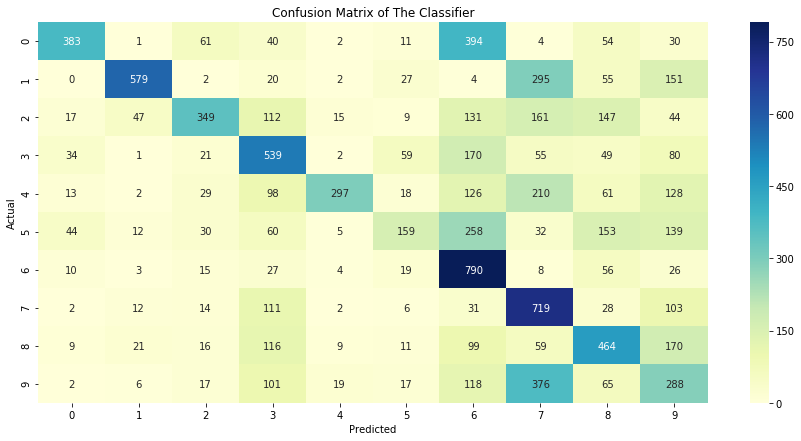

--------Display percentaged values in a tabular form--------
            0         1         2         3         4         5         6  \
0    0.390816  0.001020  0.062245  0.040816  0.002041  0.011224  0.402041   
1    0.000000  0.510132  0.001762  0.017621  0.001762  0.023789  0.003524   
2    0.016473  0.045543  0.338178  0.108527  0.014535  0.008721  0.126938   
3    0.033663  0.000990  0.020792  0.533663  0.001980  0.058416  0.168317   
4    0.013238  0.002037  0.029532  0.099796  0.302444  0.018330  0.128310   
5    0.049327  0.013453  0.033632  0.067265  0.005605  0.178251  0.289238   
6    0.010438  0.003132  0.015658  0.028184  0.004175  0.019833  0.824635   
7    0.001946  0.011673  0.013619  0.107977  0.001946  0.005837  0.030156   
8    0.009240  0.021561  0.016427  0.119097  0.009240  0.011294  0.101643   
9    0.001982  0.005946  0.016848  0.100099  0.018831  0.016848  0.116947   
sum  0.527125  0.615487  0.548693  1.223045  0.362559  0.352542  2.191748   

            7 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [30]:
# testing
label_classifier_ex4 = LabelClassifier(mnist_data_loader_ex4, multi_binary_classifier_ex4, multi_binary_trainer_ex4)
label_tester_ex4 = LabelTester(mnist_data_loader_ex4, multi_binary_classifier_ex4, multi_binary_trainer_ex4, label_classifier_ex4)
label_tester_ex4.train()
label_tester_ex4.plot_confusion_matrix()
label_tester_ex4.compute_F1()
label_tester_ex4.compute_detail_F1()

### Test with $p = 2^6$

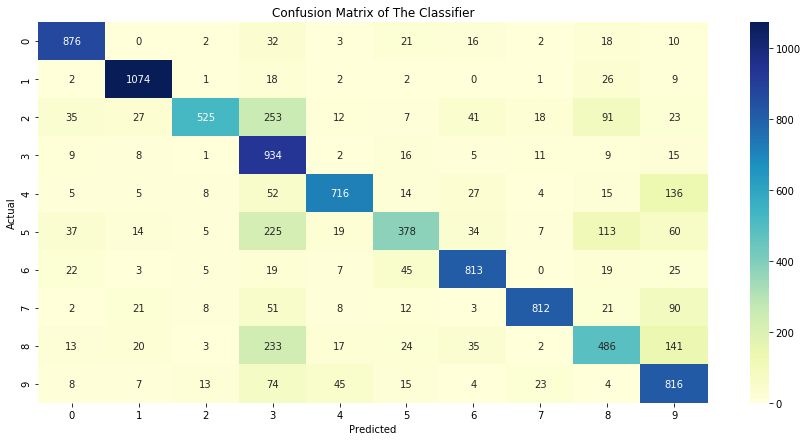

--------Display percentaged values in a tabular form--------
            0         1         2         3         4         5         6  \
0    0.893878  0.000000  0.002041  0.032653  0.003061  0.021429  0.016327   
1    0.001762  0.946256  0.000881  0.015859  0.001762  0.001762  0.000000   
2    0.033915  0.026163  0.508721  0.245155  0.011628  0.006783  0.039729   
3    0.008911  0.007921  0.000990  0.924752  0.001980  0.015842  0.004950   
4    0.005092  0.005092  0.008147  0.052953  0.729124  0.014257  0.027495   
5    0.041480  0.015695  0.005605  0.252242  0.021300  0.423767  0.038117   
6    0.022965  0.003132  0.005219  0.019833  0.007307  0.046973  0.848643   
7    0.001946  0.020428  0.007782  0.049611  0.007782  0.011673  0.002918   
8    0.013347  0.020534  0.003080  0.239220  0.017454  0.024641  0.035934   
9    0.007929  0.006938  0.012884  0.073340  0.044599  0.014866  0.003964   
sum  1.031222  1.052157  0.555350  1.905618  0.845998  0.581992  1.018077   

            7 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


<bound method LabelTester.compute_detail_F1 of <__main__.LabelTester object at 0x1b8cbf7358>>

In [32]:
# testing
label_classifier_ex6 = LabelClassifier(mnist_data_loader_ex6, multi_binary_classifier_ex6, multi_binary_trainer_ex6)
label_tester_ex6 = LabelTester(mnist_data_loader_ex6, multi_binary_classifier_ex6, multi_binary_trainer_ex6, label_classifier_ex6)
label_tester_ex6.train()
label_tester_ex6.plot_confusion_matrix()
label_tester_ex6.compute_F1()

In [35]:
label_tester_ex6.compute_detail_F1()

precision for value 0: 0.8681863230921705
recall for value 0: 0.8938775510204081
F1 score for value 0: 0.8808446455505279
precision for value 1: 1.064420218037661
recall for value 1: 1.0959183673469388
F1 score for value 1: 1.0799396681749622
precision for value 2: 0.5203171456888008
recall for value 2: 0.5357142857142857
F1 score for value 2: 0.5279034690799397
precision for value 3: 0.9256689791873142
recall for value 3: 0.9530612244897959
F1 score for value 3: 0.939165409753645
precision for value 4: 0.709613478691774
recall for value 4: 0.7306122448979592
F1 score for value 4: 0.7199597787833081
precision for value 5: 0.37462834489593655
recall for value 5: 0.38571428571428573
F1 score for value 5: 0.3800904977375565
precision for value 6: 0.8057482656095144
recall for value 6: 0.8295918367346938
F1 score for value 6: 0.8174962292609351
precision for value 7: 0.8047571853320119
recall for value 7: 0.8285714285714286
F1 score for value 7: 0.81649069884364
precision for value 8: 0.48

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Test with $p = 2^8$

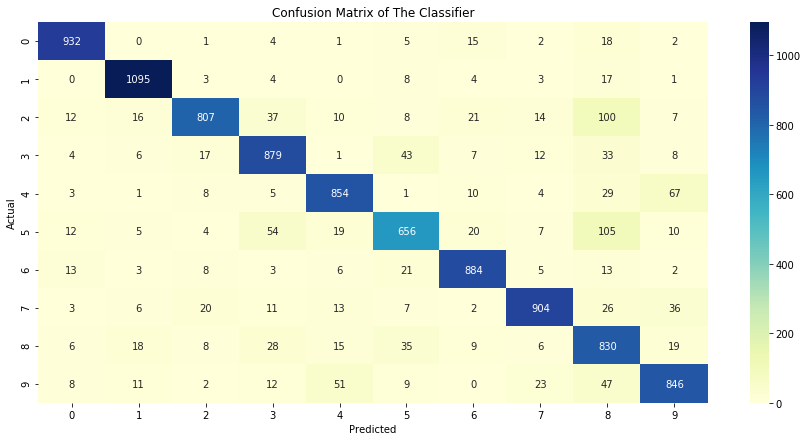

--------Display percentaged values in a tabular form--------
            0         1         2         3         4         5         6  \
0    0.951020  0.000000  0.001020  0.004082  0.001020  0.005102  0.015306   
1    0.000000  0.964758  0.002643  0.003524  0.000000  0.007048  0.003524   
2    0.011628  0.015504  0.781977  0.035853  0.009690  0.007752  0.020349   
3    0.003960  0.005941  0.016832  0.870297  0.000990  0.042574  0.006931   
4    0.003055  0.001018  0.008147  0.005092  0.869654  0.001018  0.010183   
5    0.013453  0.005605  0.004484  0.060538  0.021300  0.735426  0.022422   
6    0.013570  0.003132  0.008351  0.003132  0.006263  0.021921  0.922756   
7    0.002918  0.005837  0.019455  0.010700  0.012646  0.006809  0.001946   
8    0.006160  0.018480  0.008214  0.028747  0.015400  0.035934  0.009240   
9    0.007929  0.010902  0.001982  0.011893  0.050545  0.008920  0.000000   
sum  1.013694  1.031176  0.853105  1.033858  0.987509  0.872505  1.012656   

            7 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


<bound method LabelTester.compute_detail_F1 of <__main__.LabelTester object at 0x1c64bd2320>>

In [33]:
# testing
label_classifier_ex8 = LabelClassifier(mnist_data_loader_ex8, multi_binary_classifier_ex8, multi_binary_trainer_ex8)
label_tester_ex8 = LabelTester(mnist_data_loader_ex8, multi_binary_classifier_ex8, multi_binary_trainer_ex8, label_classifier_ex8)
label_tester_ex8.train()
label_tester_ex8.plot_confusion_matrix()
label_tester_ex8.compute_F1()

In [36]:
label_tester_ex8.compute_detail_F1()

precision for value 0: 0.9385699899295066
recall for value 0: 0.9510204081632653
F1 score for value 0: 0.9447541814495692
precision for value 1: 1.1027190332326284
recall for value 1: 1.1173469387755102
F1 score for value 1: 1.109984794728839
precision for value 2: 0.8126888217522659
recall for value 2: 0.823469387755102
F1 score for value 2: 0.8180435884439939
precision for value 3: 0.8851963746223565
recall for value 3: 0.8969387755102041
F1 score for value 3: 0.8910288900152052
precision for value 4: 0.8600201409869084
recall for value 4: 0.8714285714285714
F1 score for value 4: 0.8656867714140903
precision for value 5: 0.6606243705941591
recall for value 5: 0.6693877551020408
F1 score for value 5: 0.664977192093259
precision for value 6: 0.8902316213494461
recall for value 6: 0.9020408163265307
F1 score for value 6: 0.8960973137354282
precision for value 7: 0.9103726082578046
recall for value 7: 0.9224489795918367
F1 score for value 7: 0.9163710086163203
precision for value 8: 0.83

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Test with $p = 2^{10}$

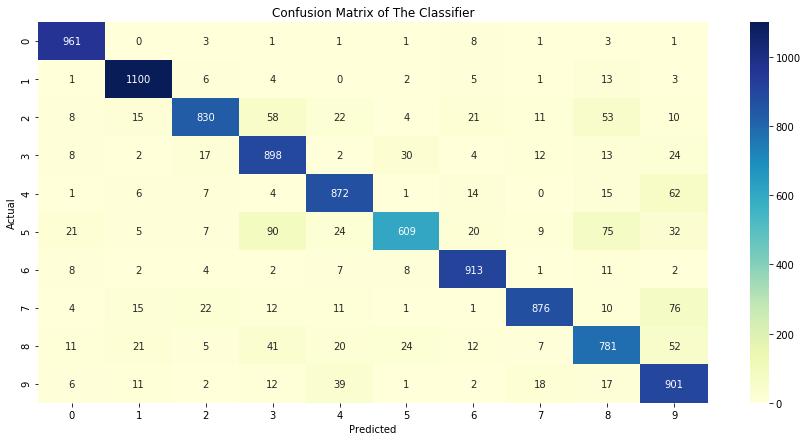

--------Display percentaged values in a tabular form--------
            0         1         2         3         4         5         6  \
0    0.980612  0.000000  0.003061  0.001020  0.001020  0.001020  0.008163   
1    0.000881  0.969163  0.005286  0.003524  0.000000  0.001762  0.004405   
2    0.007752  0.014535  0.804264  0.056202  0.021318  0.003876  0.020349   
3    0.007921  0.001980  0.016832  0.889109  0.001980  0.029703  0.003960   
4    0.001018  0.006110  0.007128  0.004073  0.887984  0.001018  0.014257   
5    0.023543  0.005605  0.007848  0.100897  0.026906  0.682735  0.022422   
6    0.008351  0.002088  0.004175  0.002088  0.007307  0.008351  0.953027   
7    0.003891  0.014591  0.021401  0.011673  0.010700  0.000973  0.000973   
8    0.011294  0.021561  0.005133  0.042094  0.020534  0.024641  0.012320   
9    0.005946  0.010902  0.001982  0.011893  0.038652  0.000991  0.001982   
sum  1.051209  1.046535  0.877110  1.122574  1.016401  0.755070  1.041858   

            7 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


<bound method LabelTester.compute_detail_F1 of <__main__.LabelTester object at 0x1b7259bb70>>

In [34]:
# testing
label_classifier_ex10 = LabelClassifier(mnist_data_loader_ex10, multi_binary_classifier_ex10, multi_binary_trainer_ex10)
label_tester_ex10 = LabelTester(mnist_data_loader_ex10, multi_binary_classifier_ex10, multi_binary_trainer_ex10, label_classifier_ex10)
label_tester_ex10.train()
label_tester_ex10.plot_confusion_matrix()
label_tester_ex10.compute_F1()
label_tester_ex10.compute_detail_F1

In [37]:
label_tester_ex10.compute_detail_F1()

precision for value 0: 0.9339164237123421
recall for value 0: 0.9806122448979592
F1 score for value 0: 0.9566948730711797
precision for value 1: 1.0689990281827018
recall for value 1: 1.1224489795918366
F1 score for value 1: 1.095072175211548
precision for value 2: 0.8066083576287658
recall for value 2: 0.8469387755102041
F1 score for value 2: 0.8262817322050772
precision for value 3: 0.8726919339164237
recall for value 3: 0.9163265306122449
F1 score for value 3: 0.8939771030363365
precision for value 4: 0.847424684159378
recall for value 4: 0.889795918367347
F1 score for value 4: 0.8680935788949725
precision for value 5: 0.5918367346938775
recall for value 5: 0.6214285714285714
F1 score for value 5: 0.6062717770034843
precision for value 6: 0.8872691933916423
recall for value 6: 0.9316326530612244
F1 score for value 6: 0.9089099054255848
precision for value 7: 0.8513119533527697
recall for value 7: 0.8938775510204081
F1 score for value 7: 0.8720756595321054
precision for value 8: 0.75

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Testing Summary

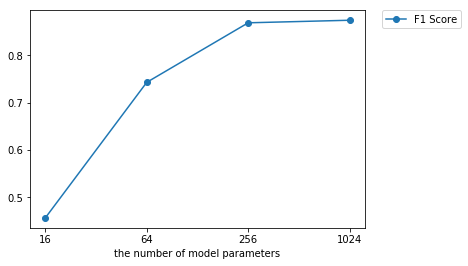

In [20]:
F1_list = [label_tester_ex4.f1_score,
           label_tester_ex6.f1_score,
          label_tester_ex8.f1_score,
          label_tester_ex10.f1_score]
str_exponents = list(map(str,exponents))

fig, ax = plt.subplots()
ax.plot(str_exponents, F1_list, marker='o', label="F1 Score")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('the number of model parameters')

plt.show()

> As the number of parameters increases the F1 Score becomes higher.